# Feature Training Experiments

In this notebook we analyse results obtained from the training sets experiments. The experimental design is as follows:

2. Let $m$ represent the machine learning model where $m$ $\in$ `["ADA", "LR", "DT", "RF"]`
3. Let $full$, $train$ and $test$ represent the full, training & testing subsets respectively. $train$ and $test$ are $0.75$ and $0.25$ of $full$ respectively
4. Let $train_{n}$ be sub-subsets of the training subset where `n` $\in$ `[0.1, 1.0]` representing the fraction of the data used
5. Let $m\prime_{n}$ be the model trained using $train_{n}$
6. Let $\hat{y}_{n, m\prime}$ be the predictions obtained from $m\prime_{n}$ on $test$. **Note that unlike the feature sets experiment, we use the same testing data here**
7. Let $d$ represent the group fairness metric where $d$ $\in$ `["DI", "SPD"]`
7. Let $v_{train, n, d}$ be data fairness metrics calculated using $train_{n}$. **Note that we do not compute fairness metrics from both subsets, because in this experiment the test subset remains unchanged**
1. Let $v_{n, m\prime, d}$ be the model fairness metrics calculated using $\hat{y}_{n, m\prime}$
1. We can reduce the granularity a bit for the analysis by considering the fairness metrics across the sub-subsets. Let $v_{train, d}$ and $v_{m\prime, d}$ represent the fairness metrics across the sub-subsets.

The objective is to analyse the following:
2. Relationship between $v_{train, d}$ and $v_{m\prime, d}$

Our hypothesis is that $v_{train, d}$ and $v_{m\prime, d}$ have some form of relationship. Another way of formulating the above statement is that the two random variables have similar distribution.

We employ two types of tests to verify our hypothesis:
1. Correlation and
2. Linear regression

In [1]:
import os
import sys
import pandas as pd
pd.set_option('display.max_rows', 100)
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from scipy.stats import shapiro, chi2
from sklearn.linear_model import LinearRegression

ROOTDIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
REPORTDIR = os.path.join(ROOTDIR, "report")
DATADIR = os.path.join(ROOTDIR, "data")
sys.path.insert(0, ROOTDIR)


In [2]:
import glob
from src.data import process

batch1 = [pd.read_csv(frame) for frame in glob.glob(os.path.join(DATADIR, "exp-training-sets-*-25.csv"))]
batch2 = [pd.read_csv(frame) for frame in glob.glob(os.path.join(DATADIR, "exp-training-sets-*-25-2.csv"))]

batch1 = pd.concat(batch1)
batch2 = pd.concat(batch2)

# we need to reset the `iteration` column for the second batch
# since we use this column as the index when calculating the
# correlation (see correlation cell below) & we cannot have
# duplicates in this column
batch2["iteration"] = batch2["iteration"] + 25
data = pd.concat([batch1, batch2])
data.shape

(60000, 25)

In [3]:
# preprocessing the data prior to analysis
# 1. fairness metrics are only calculated when privileged == None
# 2. scale fairness metrics according to zhang2021ignorance paper
# 3. combine dataset_label & protected
# 4. set the index to iteration
# 4. drop unused columns
# 4. rename column names
# 4. rename model names
data = data[data["privileged"] == "None"]
process(data)
data["dataset_label"] = data["dataset_label"] + "-" + data["protected"].str.lower()
data = data.rename(columns={
    "dataset_label": "dataset",
    "disparate_impact": "DI",
    "statistical_parity_difference": "SPD",
})
data = data.set_index("iteration")
data = data[[
    "DI",
    "SPD",
    "frac",
    "model",
    "dataset",
    "f1",
    "accuracy",
]]
data.loc[(data["model"] == "logisticregression"), "model"] = "LR"
data.loc[(data["model"] == "randomforestclassifier"), "model"] = "RF"
data.loc[(data["model"] == "adaboostclassifier"), "model"] = "ADA"
data.loc[(data["model"] == "decisiontreeclassifier"), "model"] = "DT"

data.shape

(20000, 7)

In [32]:
data.dtypes

DI          float64
SPD         float64
frac        float64
model        object
dataset      object
f1          float64
accuracy    float64
dtype: object

## Data validation

In this section I am performing some data quality checks to ensure that the data collection scripts worked as expected.

In [4]:
# here I am checking that we have data for the correct number of sub-subsets of the training set.

data.frac.unique()

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [4]:
# in this cell I am doing some manual checks to make
# sure I am sampling the data correctly by checking
# the shape of the dataset

# each vector should contain num_features*50 points

# order datasets by number of examples
datasets = ["german-age", "german-sex", "compas-race", "compas-sex", "meps-race", "bank-age", "adult-race", "adult-sex"]
models = data["model"].unique().tolist()
models.remove("None")

for dataset in datasets:
    _ = data[
        (data["dataset"] == dataset) &
        (data["model"] == "None")
    ]
    assert _.shape[0] == len(_["frac"].unique().tolist())*50


    for model in models:
        _ = data[
            (data["dataset"] == dataset) &
            (data["model"] == model)
        ]
    assert _.shape[0] == len(_["frac"].unique().tolist())*50

# Shapiro-wilk test for normality
In this section we employ the Shapiro-Wilk test for normality. The test is as follows:

- $H_o$: the population is normally distributed
- $H_1$: the population is not normally distributed

We need to test for normality since statistical analysis & formuli used later in the analysis will depend on normality assumption.

In [6]:
pvalues = {
    "dataset": [],
    "model": [],
    "DI": [],
    "SPD": [],
}

for dataset in datasets:
    _ = data[
        (data["dataset"] == dataset) &
        (data["model"] == "None")
    ]
    pvalues["dataset"].append(dataset)
    pvalues["model"].append("None")
    pvalues["DI"].append(shapiro(_["DI"]).pvalue)
    pvalues["SPD"].append(shapiro(_["SPD"]).pvalue)

    for model in models:
        _ = data[
            (data["dataset"] == dataset) &
            (data["model"] == model)
        ]
        pvalues["dataset"].append(dataset)
        pvalues["model"].append(model)
        pvalues["DI"].append(shapiro(_["DI"]).pvalue)
        pvalues["SPD"].append(shapiro(_["SPD"]).pvalue)

pvalues = pd.DataFrame(data=pvalues)
pvalues["DI"] = pvalues["DI"].apply(
    lambda x: "".join(["*" for t in [0.01, 0.05, 0.1] if x<=t])
)
pvalues["SPD"] = pvalues["SPD"].apply(
    lambda x: "".join(["*" for t in [0.01, 0.05, 0.1] if x<=t])
)
pvalues


,dataset,model,DI,SPD
0,adult-sex,None,***,***
1,adult-sex,LR,***,***
2,adult-sex,DT,,**
3,adult-sex,ADA,***,***
4,adult-sex,RF,***,***
5,bank-age,None,***,***
6,bank-age,LR,*,
7,bank-age,DT,,
8,bank-age,ADA,***,***
9,bank-age,RF,,


# Distributional Analysis
In this section we analyse the distribution of the fairness metrics. We employ the following methods:

2. Distribution of the data fairness metrics (and model fairness metrics) within each $frac$
3. Distribtion of the data fairness metrics (and model fairness metrics) across each $frac$

We limit our analysis first to the adult-sex dataset.

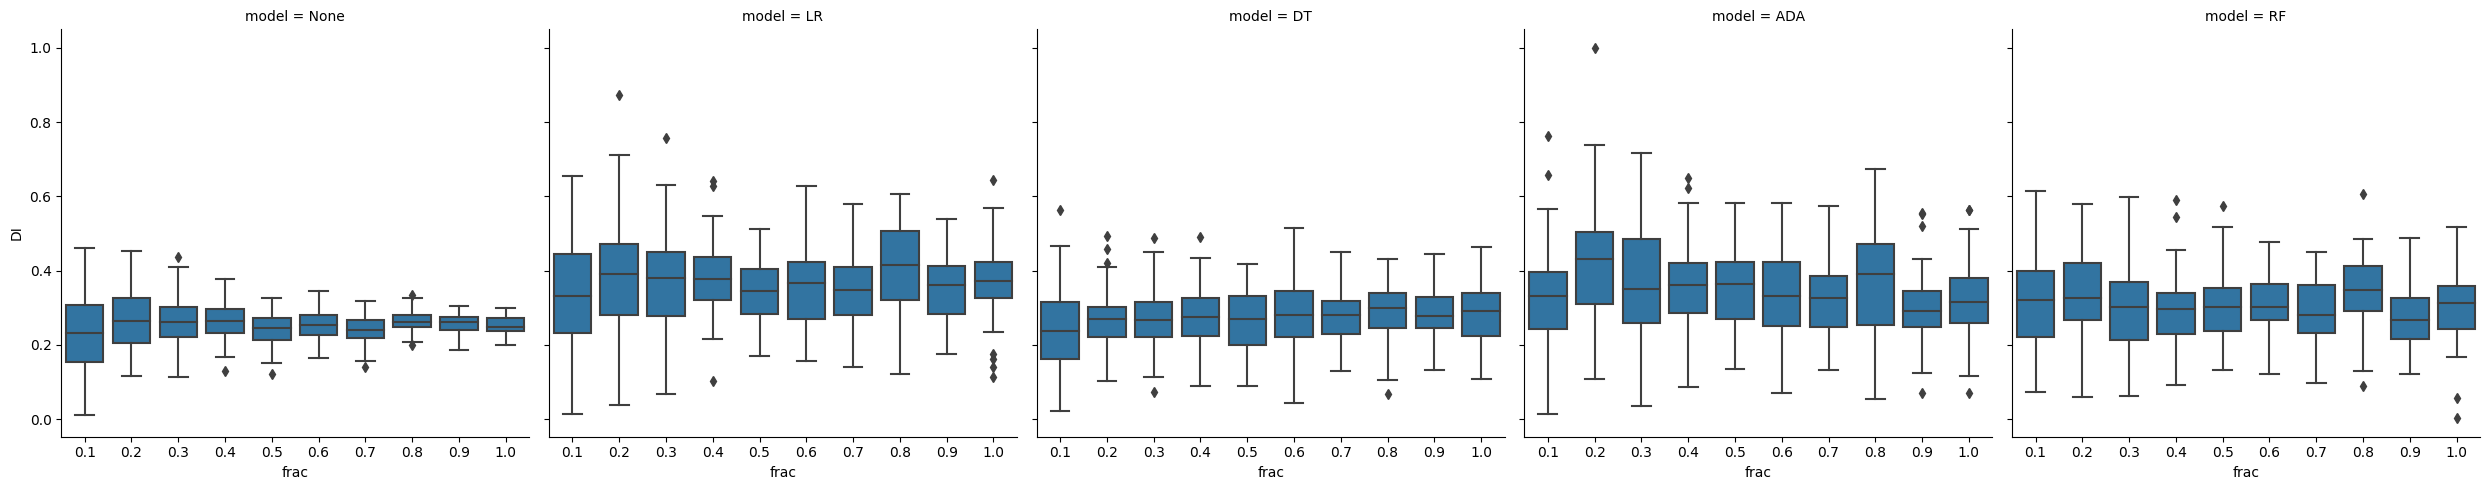

In [10]:
sns.catplot(
    data=data[data["dataset"] == "bank-age"],
    kind="box",
    x="frac",
    y="DI",
    col="model",
    color="tab:blue"
)

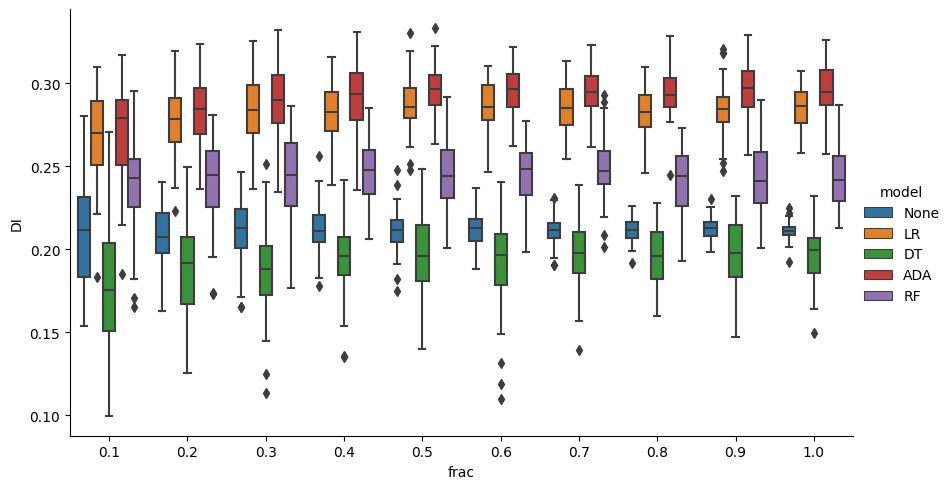

In [76]:
sns.catplot(
    data=data[data["dataset"] == "meps-race"],
    kind="box",
    x="frac",
    y="DI",
    hue="model",
    aspect=1.75,
)

The spread of the box/violin plots reduce as we increase the frac size. This could be because the variability of the sub-subset reduces as we increase the frac size. For instance, when $frac=0.1$, we are more likely to have different examples in each of our 50 iterations. This reduces as we increase the frac size.

# Relational analysis
In this section we analyse relationship between our features. In particular:

1. Relationship between DFM (and MFM) wrt frac
2. Relationship between DI & SPD

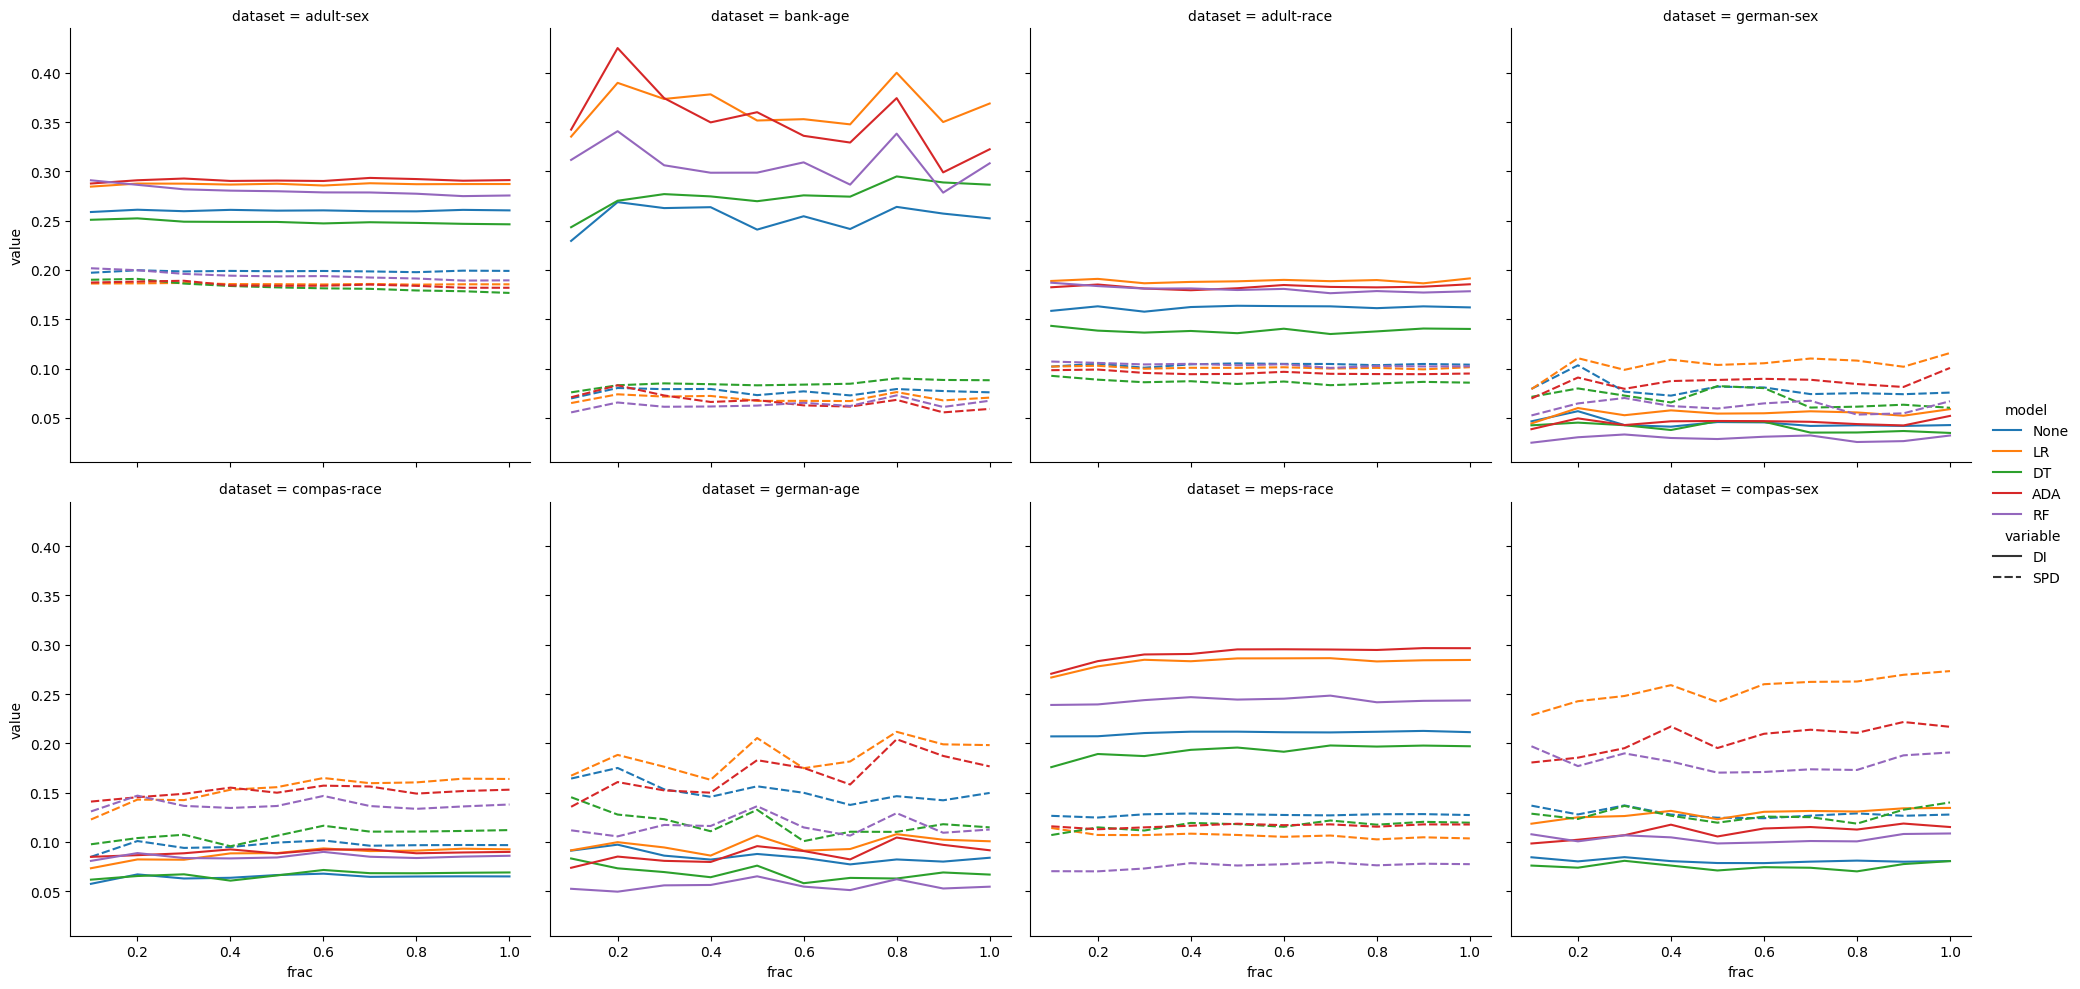

In [13]:
sns.relplot(
    kind="line",
    data=data.melt(id_vars=id_vars),
    x="frac",
    y="value",
    hue="model",
    style="variable",
    col="dataset",
    col_wrap=4,
    errorbar=None,
)

zhang2021ignorance reports that increase in training size has a negative impact on fairness (which is difficult to validate visually for all datasets). Can we replicate their results by calculating the absolute & relative changes?

DT is more fair than the DFM, meaning that the model is "learning" and making fairer decisions. It will be interesting to see how the fairness metrics & the performance metrics compare to one another. Is DT able to perform well & make fair predictions?

In most cases, DT has the lowest values (meaning it is more fair), sometimes it is even better than DFM! Can we perhaps prioritise fairness testing with DT? For instance, if DT model is giving unfair predictions, we can guarantee that other models will have worse fairness?

Luis: we don't see that much change in the metrics as we increase training size, perhaps we prioritise fairness testing with smaller subset and if that is indicating fairness issues then its already an indication that there will be fairness issue with larger subset. Because the smaller fraction of dataset is able to capture more variability of fairness issues, smaller subsets will contain higher degrees of unfairness!

**NOTE** we have outliers which is skewing the lineplot!

# Correlation
In this section we employ correlation to test if there is a relationship between the data & model metrics. From the section above, we note that the distribution of the populations are not normal.

We use the Spearman's correlation since it does not assume normality & is robust to outliers.

We also need to check the significance of the correlation by observing the pvalues of the correlations. If the pvalue is greater than 0.05 then the observed correlation is not by chance. From `scipy.stats.speakmanr` docs:

- $H_o$: the variables are uncorrelated
- $H_1$: the variables have a two-sided correlation (default value of `alternative` argument is `"two-sided"`)

In [35]:
from scipy.stats import spearmanr

indices = [[
    "DI",
    "SPD",
],
models]
corr = pd.DataFrame(columns=datasets, index=pd.MultiIndex.from_product(
    indices, names=["metric", "model"]
))
corr_pvalues = pd.DataFrame(columns=datasets, index=pd.MultiIndex.from_product(
    indices, names=["metric", "model"]
))

for d in datasets:
    _ = data[
        (data["dataset"] == d)
    ]
    for metric in ["DI", "SPD"]:
        _pivots = []
        for n in _["frac"].unique().tolist():
            _pivots.append(pd.pivot(
                data=_[_["frac"] == n],
                columns="model",
                values=metric,
            ))
        pivoted = pd.concat(_pivots)
        for model in models:
            c, p = spearmanr(pivoted[model], pivoted["None"])
            corr.loc[(metric, model), d] = c
            corr_pvalues.loc[(metric, model), d] = p

corr

german-age german-sex compas-race compas-sex meps-race  bank-age  \
metric model                                                                    
DI     LR      0.377366   0.259774    0.610876   0.494765  0.251478  0.161118   
       DT      0.178152   0.117561    0.315603    0.36158   0.20719  0.026361   
       ADA     0.354511   0.278018    0.172046   0.341801  0.234448  0.160217   
       RF      0.338088   0.113319    0.435218    0.43341  0.106394  0.095935   
SPD    LR      0.372273   0.261476    0.614609   0.496653  0.245424  0.167229   
       DT      0.183284   0.115536     0.31473   0.356129  0.195862  0.023587   
       ADA     0.350386   0.282799    0.186405   0.343258  0.273801  0.164544   
       RF      0.327624   0.114784    0.438884    0.43605  0.165151  0.099711   

             adult-race adult-sex  
metric model                       
DI     LR       0.22982  0.167482  
       DT     -0.025248  0.120302  
       ADA     0.196631  0.149729  
       RF       0.03629  0.093628  
SPD    LR      0.235562  0.166608  
       DT      -0.02215  0.102946  
       ADA     0.208509  0.175828  
       RF      0.066648  0.116142

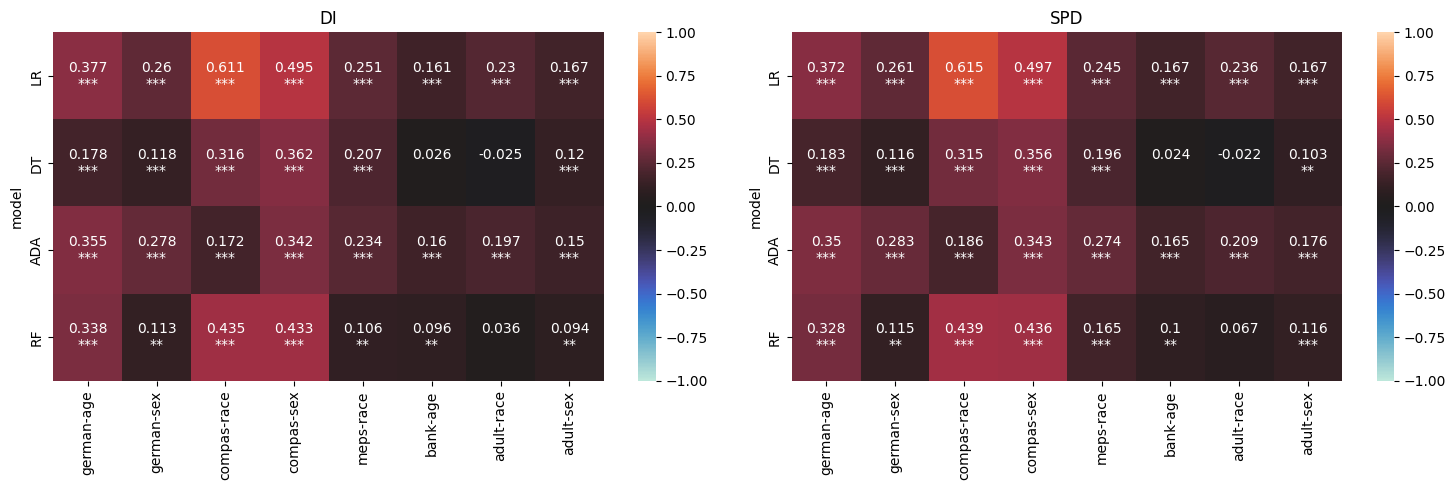

In [37]:
fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(15, 5)
)

for idx, metric in enumerate(["DI", "SPD"]):
    ax = axs[idx]
    ax.set_title(metric)
    _ = corr.loc[(metric)].astype(float)
    _corr = _.round(3).astype(str)
    _sig = corr_pvalues.loc[(metric)].applymap(
        lambda x: ''.join(['*' for t in [0.01, 0.05, 0.1] if x<=t])
    )
    annot = _corr + "\n" + _sig
    sns.heatmap(
        data=_,
        annot=annot,
        fmt="",
        vmin=-1.,
        vmax=1.,
        center=0.,
        ax=ax,
    )

fig.tight_layout()

name = "heatmap--corr--frac.pdf"
fig.savefig(os.path.join(REPORTDIR, name), format="pdf")

name = "heatmap--corr--frac.png"
fig.savefig(os.path.join(REPORTDIR, name), format="png")

In [33]:

d = {
    "dataset": [],
    "model": [],
    "metric": [],
    "intercept": [],
    "slope": [],
    "r2": [],
    "f_pvalue": [],
    "fvalue": [],
    "llf": [],
    "mse_model": [],
    "mse_resid": [],
    "mse_total": [],
    # "pvalues": [],
    "ssr": [],
    # "tvalues": [],
}

for dataset in datasets:
    for model in models:
        for metric in ["DI", "SPD"]:
            x = data.loc[
                (data["dataset"] == dataset) &
                (data["model"] == "None"),
                metric
            ].values.reshape(-1, 1)
            y = data.loc[
                (data["dataset"] == dataset) &
                (data["model"] == model),
                metric
            ].values.reshape(-1, 1)
            mod = sm.OLS(
                endog=y,
                exog=sm.tools.add_constant(x),
            )
            res = mod.fit()

            d["dataset"].append(dataset)
            d["model"].append(model)
            d["metric"].append(metric)
            d["intercept"].append(res.params[0])
            d["slope"].append(res.params[1])
            d["r2"].append(res.rsquared)
            d["f_pvalue"].append(res.f_pvalue)
            d["fvalue"].append(res.fvalue)
            d["llf"].append(res.llf)
            d["mse_model"].append(res.mse_model)
            d["mse_resid"].append(res.mse_resid)
            d["mse_total"].append(res.mse_total)
            d["ssr"].append(res.ssr)

reg = pd.DataFrame(data=d)
reg


,dataset,model,metric,intercept,slope,r2,f_pvalue,fvalue,llf,mse_model,mse_resid,mse_total,ssr
0,german-age,LR,DI,0.043878,0.626895,0.185055,6.118902e-24,113.084102,847.881610,0.223742,0.001979,0.002423,0.985314
1,german-age,LR,SPD,0.086508,0.657768,0.183238,1.070374e-23,111.725080,512.233162,0.846402,0.007576,0.009257,3.772728
2,german-age,DT,DI,0.032580,0.422922,0.089104,9.492609e-12,48.714621,834.139403,0.101830,0.002090,0.002290,1.040991
3,german-age,DT,SPD,0.055645,0.418794,0.094900,1.879550e-12,52.215154,547.802438,0.343109,0.006571,0.007245,3.272392
4,german-age,ADA,DI,0.039964,0.565034,0.146867,6.136666e-19,85.730651,830.597890,0.181763,0.002120,0.002480,1.055843
5,german-age,ADA,SPD,0.080896,0.574530,0.137677,9.125259e-18,79.509680,494.843148,0.645737,0.008121,0.009399,4.044502
6,german-age,RF,DI,0.016710,0.454598,0.161300,8.374269e-21,95.776040,967.034059,0.117656,0.001228,0.001462,0.611766
7,german-age,RF,SPD,0.039291,0.503747,0.154899,5.671485e-20,91.278759,595.091921,0.496427,0.005439,0.006423,2.708414
8,german-sex,LR,DI,0.034388,0.453655,0.103385,1.728183e-13,57.422088,1030.508328,0.054723,0.000953,0.001061,0.474591
9,german-sex,LR,SPD,0.064463,0.501521,0.108545,4.010350e-14,60.637355,695.807151,0.220427,0.003635,0.004070,1.810318


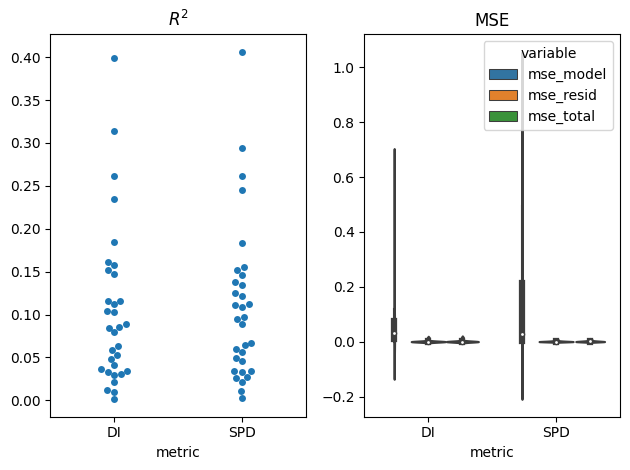

In [34]:
fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
)


ax = axs[0]
ax.set_title("$R^2$")
sns.swarmplot(
    data=reg,
    y="r2",
    x="metric",
    ax=ax,
)
ax.set_ylabel(None)

ax = axs[1]
ax.set_title("MSE")
_ = reg.loc[:, ["metric", "mse_model", "mse_resid", "mse_total"]]
_ = _.melt(id_vars=["metric"])
sns.violinplot(
    data=_,
    x="metric",
    y="value",
    hue="variable",
    ax=ax,
)
ax.set_ylabel(None)

fig.tight_layout()


# Analysis of correlation across frac
We want to analyse the correlation (and its significance) as we vary the training size. We hypothesise that the correlation depends on training data size and model complexity.

In [20]:
d = {
    "metric": [],
    "frac": [],
    "corr": [],
    "model": [],
    "dataset": [],
}

for dataset in datasets:
    _ = data[data["dataset"] == dataset]
    for metric in ["DI", "SPD"]:
        for n in _["frac"].unique().tolist():
            pivot = pd.pivot(
                data=_[_["frac"] == n],
                columns="model",
                values=metric,
            )
            for model in models:
                c, p = spearmanr(pivot[model], pivot["None"])
                d["metric"].append(metric)
                d["frac"].append(n)
                d["corr"].append(c)
                d["model"].append(model)
                d["dataset"].append(dataset)

corr = pd.DataFrame(data=d)
corr

,metric,frac,corr,model,dataset
0,DI,0.1,0.491104,LR,german-age
1,DI,0.1,0.415280,DT,german-age
2,DI,0.1,0.364955,ADA,german-age
3,DI,0.1,0.561262,RF,german-age
4,DI,0.2,0.539234,LR,german-age
...,...,...,...,...,...
635,SPD,0.9,-0.178007,RF,adult-sex
636,SPD,1.0,-0.059304,LR,adult-sex
637,SPD,1.0,-0.146699,DT,adult-sex
638,SPD,1.0,0.020024,ADA,adult-sex


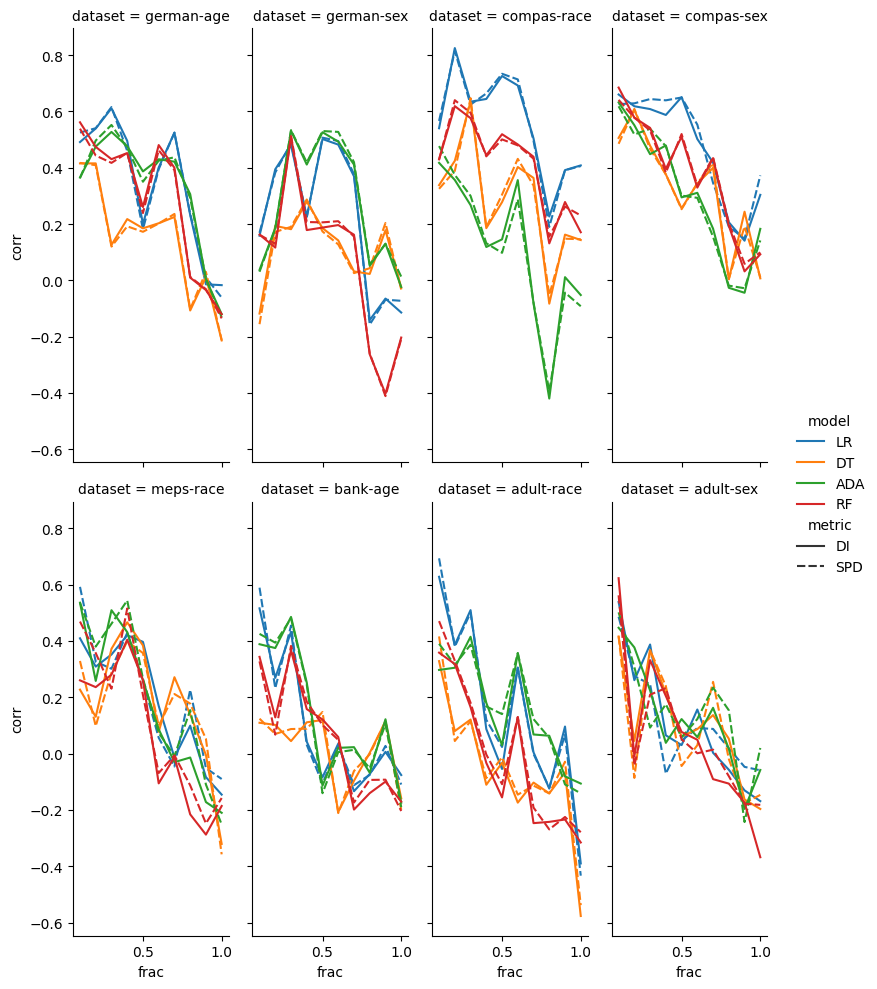

In [21]:
g = sns.relplot(
    kind="line",
    data=corr,
    hue="model",
    style="metric",
    x="frac",
    y="corr",
    errorbar=None,
    col="dataset",
    col_wrap=4,
    aspect=0.4,
)
g.tight_layout()
name = "lineplot--frac--corr.pdf"
g.savefig(os.path.join(REPORTDIR, name), format="pdf")

name = "lineplot--frac--corr.png"
g.savefig(os.path.join(REPORTDIR, name), format="png")


The correlation becomes less as we increase the training size because there is less variability in the DFM to "explain" the variability in the MFM (as seen from our experiments with full training data). We need to analyse the performance metrics & see if there is any "significant" difference in performance as we increase training size. We use this to identify a cut-off for frac where we are guaranteed to see the most variety of fairness issues in the dataset (typically will always be in smaller subsets). Then we can show that correlation is strong & back it up with linear regression.

# Identifying $frac$ that captures variety of fairness issues
From the full-data experiment we observed that the DFM cannot explain the variability in MFM in majority of the cases. Thus we want to identify the fraction of training data that can capture maximum number of different fairness issues in the dataset with acceptable performance.

We conduct statistical hypothesis testing using the student t-test. We want to test the significance in difference between the performance metrics when $frac=1.0$ vs. other training sizes. We choose the frac with the most significant rise in the count.

$H_o$: the 2 independent samples have identical average
$H_1$: the 2 independent samples do not have identical average

Lets set $\alpha$ to 0.05. This means that when $\alpha < 0.05$ we can reject the null hypothesis which means there is significant difference between the two samples.

In [22]:
from scipy.stats import ttest_ind

d = {
    "metric": [],
    "model": [],
    "dataset": [],
    "start": [],
    "stop": [],
    "pvalue": [],
}

# I want to compare frac 1 to all other fracs now
stops = data["frac"].unique().tolist()
stops.reverse()

for dataset in datasets:
    for model in models:
        for metric in ["accuracy", "f1"]:
            _ = data[
                (data["dataset"] == dataset) &
                (data["model"] == model)
            ]
            for stop in stops:
                _start = _.loc[_["frac"] == 1.0, metric]
                _stop = _.loc[_["frac"] == stop, metric]
                d["metric"].append(metric)
                d["model"].append(model)
                d["dataset"].append(dataset)
                d["start"].append(1.0)
                d["stop"].append(stop)
                d["pvalue"].append(ttest_ind(_start, _stop).pvalue)

cutoff = pd.DataFrame(data=d)
cutoff.head()

,metric,model,dataset,start,stop,pvalue
0,accuracy,LR,german-age,1.0,1.0,1.000000
1,accuracy,LR,german-age,1.0,0.9,0.690193
2,accuracy,LR,german-age,1.0,0.8,0.686160
3,accuracy,LR,german-age,1.0,0.7,0.223977
4,accuracy,LR,german-age,1.0,0.6,0.759229


In [23]:
d = {
    "frac": [],
    "count": [],
}

for frac in cutoff.stop.unique():
    count = cutoff.loc[(cutoff["stop"] == frac) & (cutoff["pvalue"] < 0.05)].shape[0]
    d["frac"].append(frac)
    d["count"].append(count)

cutoff_count = pd.DataFrame(data=d)
cutoff_count

,frac,count
0,1.0,0
1,0.9,3
2,0.8,5
3,0.7,16
4,0.6,15
5,0.5,35
6,0.4,44
7,0.3,50
8,0.2,58
9,0.1,63


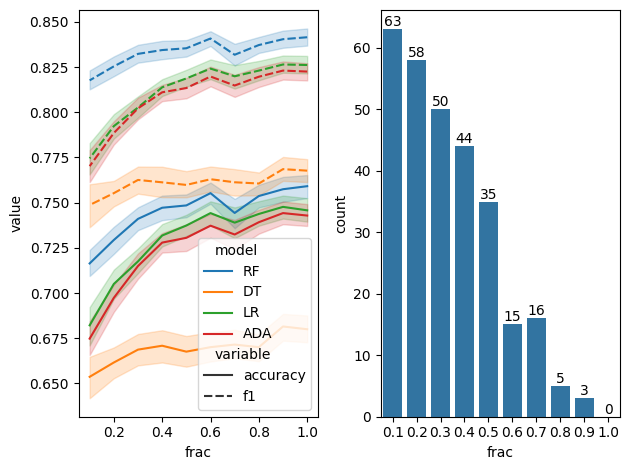

In [24]:
fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
)

ax = axs[0]
_ = data.loc[
    (data["model"] != "None") &
    (data["dataset"] == "german-age"),
    ["frac", "model", "accuracy", "f1"]
].sort_values(by="frac", ascending=False)
sns.lineplot(
    data=pd.melt(_, id_vars=["frac", "model"]),
    x="frac",
    y="value",
    hue="model",
    style="variable",
    sort=False,
    ax=ax,
)

ax = axs[1]
sns.barplot(
    data=cutoff_count,
    x="frac",
    y="count",
    # order=stops,
    color="tab:blue",
    ax=ax,
)
ax.bar_label(ax.containers[0], label_type="edge")
fig.tight_layout()

name = "training-set-frac-threshold.pdf"
fig.savefig(os.path.join(REPORTDIR, name), format="pdf")

name = "training-set-frac-threshold.png"
fig.savefig(os.path.join(REPORTDIR, name), format="png")

## Correlation $frac=0.6$
We choose $frac=0.6$ as our threshold. All further experiments are conducted using this subset. Next we investigate correlation & linear regression.

In [25]:
from scipy.stats import spearmanr

indices = [[
    "DI",
    "SPD",
],
models]
corr = pd.DataFrame(columns=datasets, index=pd.MultiIndex.from_product(
    indices, names=["metric", "model"]
))
corr_pvalues = pd.DataFrame(columns=datasets, index=pd.MultiIndex.from_product(
    indices, names=["metric", "model"]
))

for d in datasets:
    _ = data[
        (data["dataset"] == d) &
        (data["frac"] == 0.6)
    ]
    for metric in ["DI", "SPD"]:
        pivoted = pd.pivot(
            data=_,
            columns="model",
            values=metric,
        )
        for model in models:
            c, p = spearmanr(pivoted[model], pivoted["None"])
            corr.loc[(metric, model), d] = c
            corr_pvalues.loc[(metric, model), d] = p

corr

german-age german-sex compas-race compas-sex meps-race  bank-age  \
metric model                                                                    
DI     LR       0.40072   0.482065    0.692101   0.501849  0.169268  0.035102   
       DT      0.202689   0.141801    0.402449   0.343962  0.077551 -0.207299   
       ADA      0.43007   0.492725    0.355966   0.310828  0.086291  0.020408   
       RF      0.480396   0.196259    0.482641   0.329268  -0.10569   0.05892   
SPD    LR       0.39467   0.494646    0.713517   0.552941  0.056327   0.02934   
       DT      0.201729   0.127587    0.431357   0.344826  0.098968 -0.211236   
       ADA     0.425028   0.527107    0.287491   0.292965  0.073517  0.005234   
       RF      0.461956   0.209993    0.479376   0.336759 -0.068908  0.048836   

             adult-race adult-sex  
metric model                       
DI     LR      0.305738  0.156591  
       DT     -0.174166  0.086963  
       ADA     0.357407  0.058727  
       RF      0.129316   0.04922  
SPD    LR       0.30449    0.0909  
       DT     -0.145738   0.02982  
       ADA     0.356255  0.122785  
       RF      0.130084  0.001104

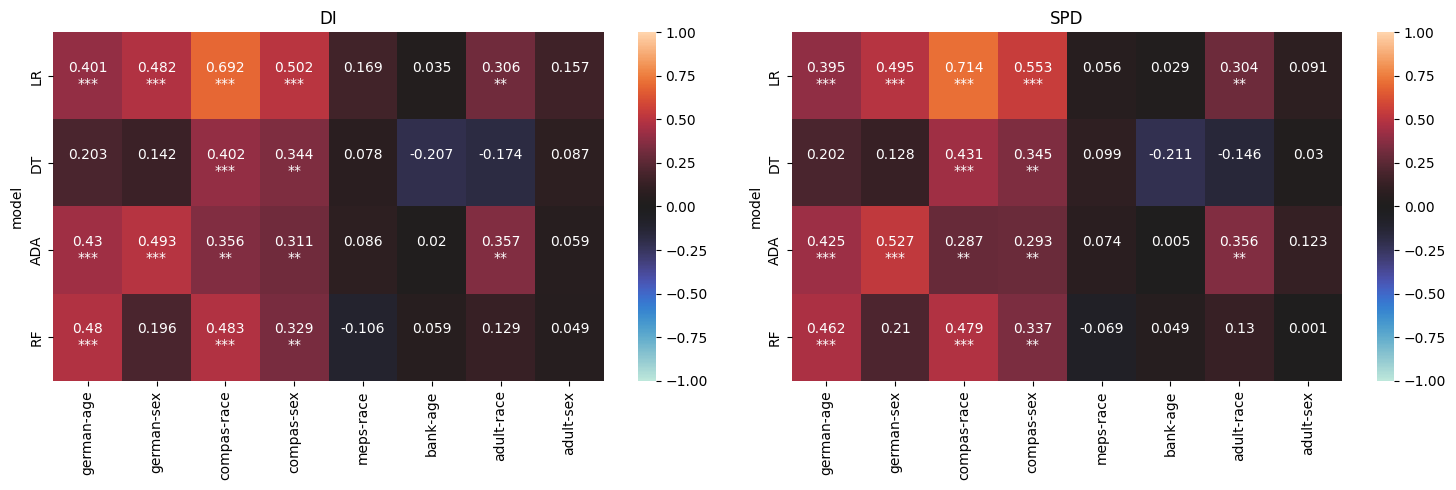

In [26]:
import numpy as np

fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(15, 5)
)

for idx, metric in enumerate(["DI", "SPD"]):
    ax = axs[idx]
    ax.set_title(metric)
    _ = corr.loc[(metric)].astype(float)
    _corr = _.round(3).astype(str)
    _sig = corr_pvalues.loc[(metric)].applymap(
        lambda x: ''.join(['*' for t in [0.01, 0.05, 0.1] if x<=t])
    )
    annot = _corr + "\n" + _sig
    sns.heatmap(
        data=_,
        annot=annot,
        fmt="",
        vmin=-1.,
        vmax=1.,
        center=0.,
        ax=ax,
    )

fig.tight_layout()

name = "heatmap--corr--training-sets-frac.pdf"
fig.savefig(os.path.join(REPORTDIR, name), format="pdf")

name = "heatmap--corr--training-sets-frac.png"
fig.savefig(os.path.join(REPORTDIR, name), format="png")

## Linear Regression $frac=0.6$
In this section we employ linear regression to analyse relationship between the data & model fairness metrics.

In [27]:

d = {
    "dataset": [],
    "model": [],
    "metric": [],
    "intercept": [],
    "slope": [],
    "r2": [],
    "f_pvalue": [],
    "fvalue": [],
    "llf": [],
    "mse_model": [],
    "mse_resid": [],
    "mse_total": [],
    # "pvalues": [],
    "ssr": [],
    # "tvalues": [],
}

for dataset in datasets:
    for model in models:
        for metric in ["DI", "SPD"]:
            x = data.loc[
                (data["dataset"] == dataset) &
                (data["model"] == "None") &
                (data["frac"] == 0.6),
                metric
            ].values.reshape(-1, 1)
            y = data.loc[
                (data["dataset"] == dataset) &
                (data["model"] == model) &
                (data["frac"] == 0.6),
                metric
            ].values.reshape(-1, 1)
            mod = sm.OLS(
                endog=y,
                exog=sm.tools.add_constant(x),
            )
            res = mod.fit()

            d["dataset"].append(dataset)
            d["model"].append(model)
            d["metric"].append(metric)
            d["intercept"].append(res.params[0])
            d["slope"].append(res.params[1])
            d["r2"].append(res.rsquared)
            d["f_pvalue"].append(res.f_pvalue)
            d["fvalue"].append(res.fvalue)
            d["llf"].append(res.llf)
            d["mse_model"].append(res.mse_model)
            d["mse_resid"].append(res.mse_resid)
            d["mse_total"].append(res.mse_total)
            d["ssr"].append(res.ssr)

reg = pd.DataFrame(data=d)
reg


,dataset,model,metric,intercept,slope,r2,f_pvalue,fvalue,llf,mse_model,mse_resid,mse_total,ssr
0,german-age,LR,DI,0.027737,0.755616,0.160091,3.989386e-03,9.149026,89.490781,1.556020e-02,0.001701,0.001984,0.081636
1,german-age,LR,SPD,0.054983,0.799368,0.163984,3.533168e-03,9.415150,56.847736,5.909290e-02,0.006276,0.007354,0.301265
2,german-age,DT,DI,0.016873,0.491356,0.074921,5.442701e-02,3.887439,89.611524,6.579704e-03,0.001693,0.001792,0.081243
3,german-age,DT,SPD,0.028980,0.478772,0.080334,4.608714e-02,4.192884,62.254334,2.119818e-02,0.005056,0.005385,0.242676
4,german-age,ADA,DI,0.023942,0.796577,0.164061,3.524701e-03,9.420426,87.582040,1.729295e-02,0.001836,0.002151,0.088113
5,german-age,ADA,SPD,0.047068,0.854053,0.170304,2.898988e-03,9.852489,54.674253,6.745456e-02,0.006846,0.008083,0.328630
6,german-age,RF,DI,-0.000789,0.660891,0.153751,4.858636e-03,8.720885,94.989818,1.190345e-02,0.001365,0.001580,0.065517
7,german-age,RF,SPD,0.005148,0.730959,0.142182,6.948811e-03,7.955940,57.110916,4.941146e-02,0.006211,0.007092,0.298111
8,german-sex,LR,DI,0.017640,0.814841,0.225984,4.853488e-04,14.014216,115.768978,8.331248e-03,0.000594,0.000752,0.028535
9,german-sex,LR,SPD,0.035384,0.866074,0.215706,6.795940e-04,13.201549,81.294176,3.116412e-02,0.002361,0.002948,0.113311


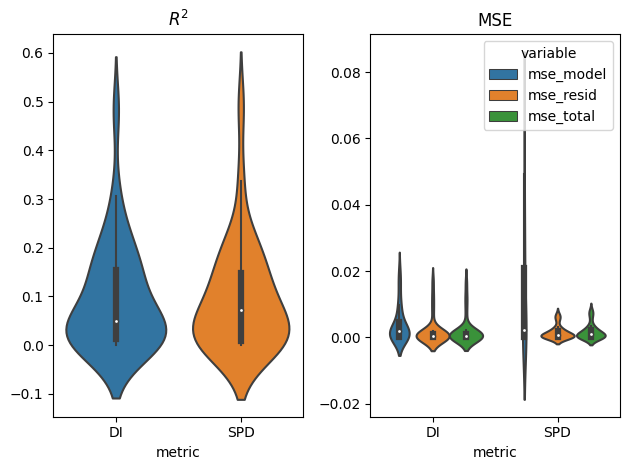

In [28]:
fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
)


ax = axs[0]
ax.set_title("$R^2$")
sns.violinplot(
    data=reg,
    y="r2",
    x="metric",
    ax=ax,
)
ax.set_ylabel(None)

ax = axs[1]
ax.set_title("MSE")
_ = reg.loc[:, ["metric", "mse_model", "mse_resid", "mse_total"]]
_ = _.melt(id_vars=["metric"])
sns.violinplot(
    data=_,
    x="metric",
    y="value",
    hue="variable",
    ax=ax,
)
ax.set_ylabel(None)

fig.tight_layout()
name = "violinplot--metric--r2-mse--frac.pdf"
fig.savefig(os.path.join(REPORTDIR, name), format="pdf")

name = "violinplot--metric--r2-mse--frac.png"
fig.savefig(os.path.join(REPORTDIR, name), format="png")

# Analysis of fairness & performance in Decision Trees

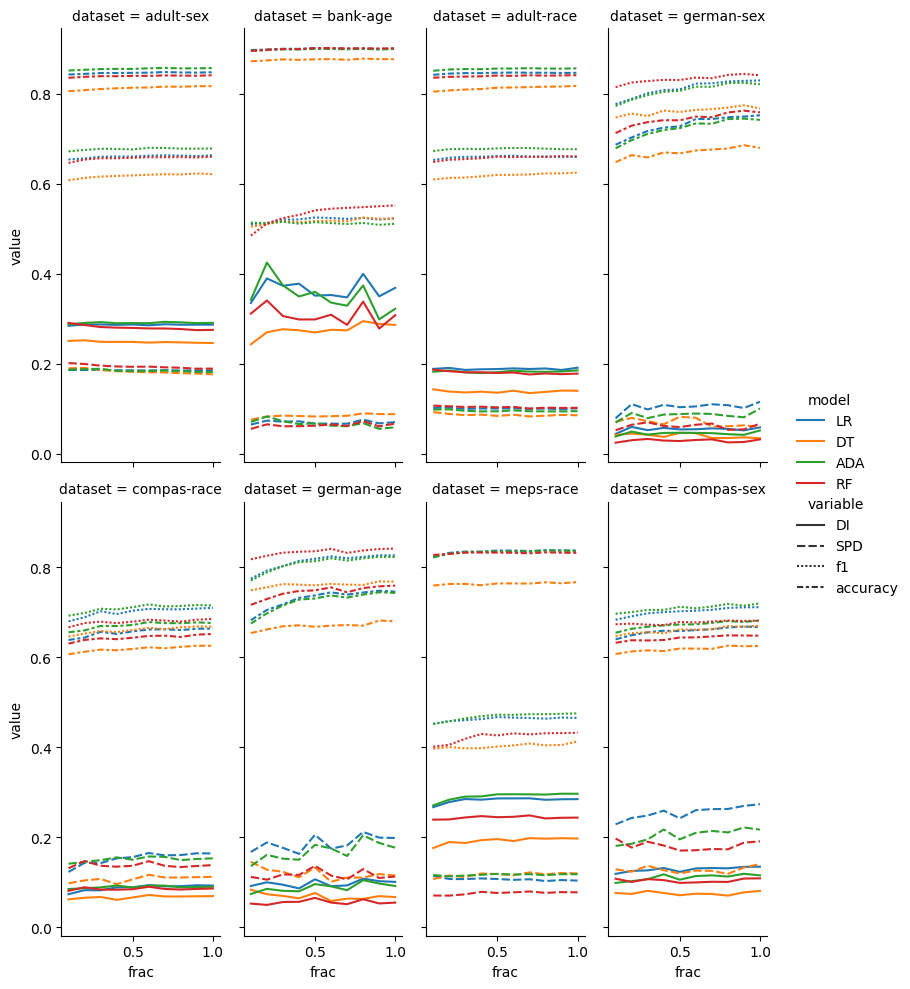

In [10]:
_ = data[data["model"] != "None"]
g = sns.relplot(
    kind="line",
    data=_.melt(id_vars=["dataset", "frac", "model"]),
    hue="model",
    style="variable",
    x="frac",
    y="value",
    errorbar=None,
    col="dataset",
    col_wrap=4,
    aspect=0.4,
)

g.tight_layout()